# **Stacking with QSVM and LGBM as base classifiers and Logistic regressor(LR) as meta classifier**
In this tutorial, we will see the classical stacking of QSVM,LGBM and LR algorithms, with QSVM, LGBM as base classifiers and LR as meta classifier. The stacking algorithm works as below\
1) The base classifiers are trained with training data\
2) The trained base classifiers are used to test both training data and testing data\
3) The output labels from base classifiers on training and testing data are appended as features to original training and testing data\
4) Now we train the meta classifier with appended training data and test it on appended testing data to get final prediction values



Below is detailed explanation and implementation of each of above steps


We first need to install qiskit and qiskit_machine_learning modules if not already installed. We start by importing all necessary libraries from qiskit,  qiskit\_machine\_learning and some related modules as shown in below cells.

In [1]:
!pip install qiskit qiskit_machine_learning
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import QuantumKernel

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist

from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

###Data set
We use ethereum networks data to perform stacking. We consider 7 features for data set\
1) Degree - In degree, Out degree, Total degree\
2) Strength - In strength, Out strength, Total strength\
3) Number of neighbours

The files 'train_data.npy' and 'train_labels.npy' have 960 training data points and corresponding labels respectively, first 160 training data points are of phishing nodes and next 800 are of non-phishing nodes. The files 'test_data.npy' and 'test_labels.npy' have 11000 testing data points and corresponding labels respectively, first 1000 testing data points are of phishing nodes and next 10000 are of non-phishing nodes.


let us choose 320 training data points to perform stacking, 160 phishing and 160 non-phishing. Even though the real life data is highly imbalanced, we choose equal number of phishing and non-phishing nodes for training our classifiers and then test on imbalanced testing data. With different experiments on this data set, taking balanced training data proved more effective in giving good results

In [4]:
X = pd.read_csv("/content/drive/MyDrive/SC-ML Research/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("/content/drive/MyDrive/SC-ML Research/y.csv", index_col=None)['went_on_backorder']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No backorder', round(y.value_counts()[0]/len(y) * 100,2), '% of the dataset')
print('Backorder', round(y.value_counts()[1]/len(y) * 100,2), '% of the dataset')

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No backorder 99.3 % of the dataset
Backorder 0.7 % of the dataset
Train: [ 259572  259620  259654 ... 1775315 1775316 1775317] Test: [     0      1      2 ... 355895 355896 355897]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [259572 259620 259654 ... 711229 711230 711231]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 562975  562992  563216 ... 1066527 1066528 1066529]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 913555  913679  913781 ... 1549977 1550291 1550807]
Train: [      0       1       2 ... 1549977 1550291 1550807] Test: [1420136 1420137 1420138 ... 1775315 1775316 1775317]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99296253 0.00703747]
[0.99296181 0.00703819]


In [5]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))
print("Before UnderSampling, counts of label '1': {}".format(sum(original_ytrain == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(original_ytrain == 0)))

Length of X (train): 1420255 | Length of y (train): 1420255
Length of X (test): 355063 | Length of y (test): 355063
Before UnderSampling, counts of label '1': 9995
Before UnderSampling, counts of label '0': 1410260 



In [6]:
print("test, counts of label '1': {}".format(sum(original_ytest == 1)))
print("test, counts of label '0': {} \n".format(sum(original_ytest == 0)))

test, counts of label '1': 2499
test, counts of label '0': 352564 



In [7]:
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, RandomizedSearchCV

sm1 = NearMiss(sampling_strategy={0:160,1:160})
Xsm_train, ysm_train = sm1.fit_resample(original_Xtrain, original_ytrain)
sm2 = NearMiss(sampling_strategy={0:200,1:67})
Xsm_test, ysm_test = sm2.fit_resample(original_Xtest, original_ytest)

In [8]:
print('After Sampling, the shape of test_X: {}'.format(Xsm_test.shape))
print('After Sampling, the shape of test_y: {} \n'.format(ysm_test.shape))

print("After Sampling, counts of label '1': {}".format(sum(ysm_test == 1)))
print("After Sampling, counts of label '0': {}".format(sum(ysm_test == 0)))

After Sampling, the shape of test_X: (267, 14)
After Sampling, the shape of test_y: (267,) 

After Sampling, counts of label '1': 67
After Sampling, counts of label '0': 200


In [9]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 7)
 
trainX = pca.fit_transform(Xsm_train)
testX = pca.transform(Xsm_test)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.60956345, 0.1612372 , 0.08832099, 0.05199432, 0.02882912,
       0.02425017, 0.01719128])

In [10]:
train_data = trainX.astype("float32")
train_labels2 = ysm_train.astype("float32")
test_data = testX.astype("float32")
test_labels2 = ysm_test.astype("float32")

In [11]:
train_labels = np.array([train_labels2]).astype("float32")
train_labels = train_labels.reshape(len(train_labels2),1)
col = []
for i in train_labels2:
    if i==1:
        col.append(0)
    else:
        col.append(1)

col2 = np.array([col]).astype("float32")
col2 = col2.reshape(len(col),1)
train_labels = np.concatenate((train_labels,col2), axis = 1).astype("float32")

In [12]:
test_labels = np.array([test_labels2]).astype("float32")
test_labels = test_labels.reshape(len(test_labels2),1)
col = []
for i in test_labels2:
    if i==1:
        col.append(0)
    else:
        col.append(1)

col2 = np.array([col]).astype("float32")
col2 = col2.reshape(len(col),1)
test_labels = np.concatenate((test_labels,col2), axis = 1).astype("float32")

In [13]:
import gc
del Xsm_train,ysm_train,Xsm_test,ysm_test,original_Xtrain,original_Xtest,original_ytrain,original_ytest,train_unique_label,train_counts_label,test_unique_label,test_counts_label,X,y
gc.collect()

154

In [14]:
#Parameters in LightGBM
learning_rate = [0.01]
n_estimators = [500] # tree number

#Create the param grid for LightGBM
param_grid_lgbm = {'learning_rate': learning_rate,
'n_estimators': n_estimators,
'objective': ['binary'],
'class_weight': [{0: 1, 1: 3}]
}
print(param_grid_lgbm)

{'learning_rate': [0.01], 'n_estimators': [500], 'objective': ['binary'], 'class_weight': [{0: 1, 1: 3}]}


In [15]:
#gc.disable()

# Classical SVM training and testing
We perform classical support vector machine classification to compare our final results

In [16]:
'''
#training classical SVM with rbf kernel

print("*** Training a classical SVM classifier with rbf Kernel ***")

#converting two dimensional labels to 1D
train_labels_svm = train_labels[:,0]
test_labels_svm = test_labels[:,0]

clf = svm.SVC(kernel='rbf')
start_time = time()
clf.fit(train_data, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("training time for classical SVM : ", duration)
y_pred=clf.predict(test_data)
print(confusion_matrix(test_labels_svm, y_pred))
print(classification_report(test_labels_svm, y_pred))
'''

'\n#training classical SVM with rbf kernel\n\nprint("*** Training a classical SVM classifier with rbf Kernel ***")\n\n#converting two dimensional labels to 1D\ntrain_labels_svm = train_labels[:,0]\ntest_labels_svm = test_labels[:,0]\n\nclf = svm.SVC(kernel=\'rbf\')\nstart_time = time()\nclf.fit(train_data, train_labels_svm)\nend_time = time()\nduration = end_time - start_time\nprint("training time for classical SVM : ", duration)\ny_pred=clf.predict(test_data)\nprint(confusion_matrix(test_labels_svm, y_pred))\nprint(classification_report(test_labels_svm, y_pred))\n'

# lgbm_qsvm_as_base_lr_meta_stacking

600 (train 300:300)\
200 (test 100:100)

# **Stacking**
###Initializing the classifiers
Initialize the two base classifiers QSVM and LGBM. ZZ feature map is used to calculate kernel matrix for QSVM classifier. 
It can be calculated using below equation\
$K(\vec{x_i},\vec{x_j}) =K_{ij}= \vert\langle\phi^\dagger(\vec{x_j})\vert\phi(\vec{x_i})\rangle\vert^2$, where $x_i,x_j\in X$(training data set) and $\phi$ represents feature map 

Statevector simulator is used to simulate the results of quantum computer, it can be replaced with backend for harware results

In this tutorial we are considering two base classifiers, the second one is classical ML algorithm LGBM

Over these two base classifiers we use Logistic regression as meta classifier

In [17]:
#@title
#converting two dimensional labels to 1D
train_labels_svm = train_labels[:,0]
test_labels_svm = test_labels[:,0]

In [18]:
#@title
seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map to calculate kernel of QSVM
feature_map = ZZFeatureMap(feature_dim)

#initialize LGBM classifier
num_boost_round = 1000
early_stopping_rounds = 10
clf = lgb.LGBMClassifier(tree_learner='voting',num_machines=2)

#initialize kernel of QSVM
kernel = QuantumKernel(feature_map=feature_map,
                             quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                            shots=1,
                                            seed_simulator=seed,
                                                              seed_transpiler=seed))

#initialize QSVM
qsvc = QSVC(quantum_kernel=kernel)
lr = LogisticRegression()

###Training the base classifiers
In the following cells we train the base classifiers QSVM and LGBM using 320 training data points, then we predict the labels of both training data and testing data using the trained classifiers, the labels we obtained are added as features to initial training and testing data sets, thus our final training data and testing data with appended features consists of total 9 features(one label is added from each classifier)

In [19]:
#@title
#train base classifiers and append features to data
import sklearn
#def level_0():
from dask.distributed import Client
from joblib import parallel_backend

with parallel_backend('multiprocessing'):
        #Use QSVM and LGBM on train data, append the predicted labels on train data to train data features
        grid_lgbm = sklearn.model_selection.GridSearchCV(estimator = clf, 
                                                        param_grid = param_grid_lgbm, 
                                                        cv=5, verbose=3, scoring='roc_auc', n_jobs = 4)

      
        grid_lgbm.fit(train_data,train_labels_svm)
        grid_lgbm = grid_lgbm
        grid_result1 = grid_lgbm.best_estimator_
        print(grid_lgbm.best_params_)
        b = grid_result1.predict(train_data)
        label_2 = np.reshape(b,(len(b),1))
        e = grid_result1.predict(test_data)
        label_5 = np.reshape(e,(len(e),1))
        print('done1')
        gc.collect()

        qsvc.fit(train_data, train_labels_svm)
        c = qsvc.predict(train_data)
        label_3 = np.reshape(c,(len(c),1))
        t1 = np.append(train_data,label_2,1)
        train_added = np.append(t1,label_3,1)
        print('done2')
        gc.collect()

        f = qsvc.predict(test_data)
        label_6 = np.reshape(f,(len(f),1))
        t3 = np.append(test_data,label_5,1)
        test_added = np.append(t3,label_6,1)
        
        print('done3')
        gc.collect()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.847 total time=   3.4s
[CV 2/5] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.862 total time=   4.2s
[CV 4/5] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.952 total time=   4.5s
[CV 1/5] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.880 total time=   4.8s
[CV 5/5] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.921 total time=   1.3s
{'class_weight': {0: 1, 1: 3}, 'learning_rate': 0.01, 'n_estimators': 500, 'objective': 'binary'}
done1
done2
done3


###Training the meta classifier
The LR classifier is now trained with training data of 320 data points with 9 features (7 features + one feature from prediction label of that particular training data point using QSVM + one feature from prediction label of that particular training data point using LGBM)

In [20]:
#@title
# predict on appended test data
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import *

lr.fit(train_added, train_labels_svm)
y_pred_1 = lr.predict(test_added)
probs = lr.predict_proba(test_added)
preds = probs[:,1]
classes = ['No Backorder','Backorder']
print(classification_report(test_labels_svm,y_pred_1,target_names=classes))
print(classification_report_imbalanced(test_labels_svm,y_pred_1,target_names=classes))
print(confusion_matrix(test_labels_svm,y_pred_1))

              precision    recall  f1-score   support

No Backorder       0.91      0.29      0.44       200
   Backorder       0.30      0.91      0.45        67

    accuracy                           0.45       267
   macro avg       0.60      0.60      0.45       267
weighted avg       0.75      0.45      0.44       267

                    pre       rec       spe        f1       geo       iba       sup

No Backorder       0.91      0.29      0.91      0.44      0.51      0.25       200
   Backorder       0.30      0.91      0.29      0.45      0.51      0.28        67

 avg / total       0.75      0.45      0.75      0.44      0.51      0.26       267

[[ 58 142]
 [  6  61]]


###Get final prediction
We test the appended data set with 9 features (7 features + one feature from prediction label of that particular test data point using QSVM + one feature from prediction label of that particular test data point using LGBM) using the trained meta classifier (LR) and get our final prediction results

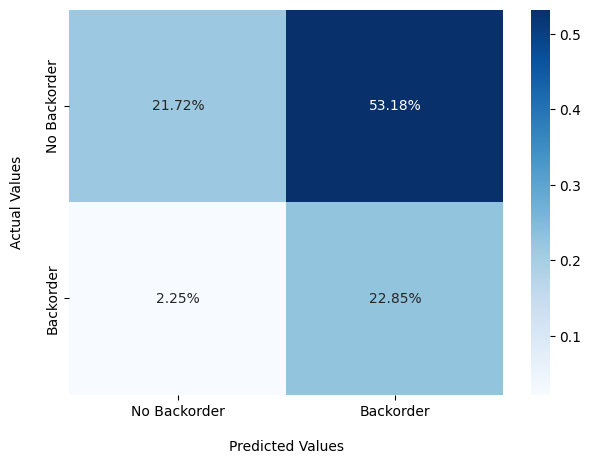

No Backorders Detected (True Negatives):  58
No Backorders Incorrectly Detected (False Positives):  142
Backorders Missed (False Negatives):  6
Backorders Detected (True Positives):  61
Total Backorders:  67


In [21]:
#@title
cm = confusion_matrix(test_labels_svm,y_pred_1)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.savefig('cm1.png')
plt.show()

print('No Backorders Detected (True Negatives): ', cm[0][0])
print('No Backorders Incorrectly Detected (False Positives): ', cm[0][1])
print('Backorders Missed (False Negatives): ', cm[1][0])
print('Backorders Detected (True Positives): ', cm[1][1])
print('Total Backorders: ', np.sum(cm[1]))

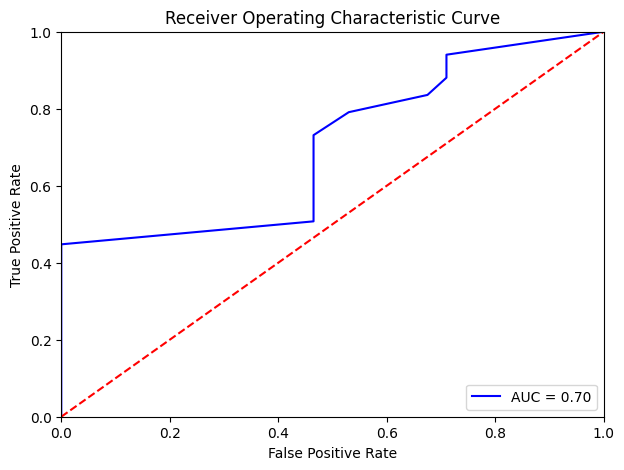

In [22]:
#@title
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test_labels_svm, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_curve1.png')
plt.show()

# vqc_base_lgbm_meta_stacking

In [ ]:
#converting two dimensional labels to 1D
train_labels_svm = train_labels[:,0]
test_labels_svm = test_labels[:,0]

seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map of VQC
feature_map = ZZFeatureMap(feature_dim)

#ansatz we use in VQC
ansatz = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps = 2)

#initialize VQC
# initialize VQC with the modified quantum instance
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator

# initialize VQC with the modified quantum instance
vqc = VQC(feature_map=feature_map,
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=100),
                 quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                 seed_simulator=seed,
                                                 seed_transpiler=seed)
                 )

#initialize LGBM classifier
clf = lgb.LGBMClassifier()

#train base classifiers and append features to data
import sklearn
from joblib import parallel_backend

with parallel_backend('multiprocessing'):      
    #Use VQC and train data, append the predicted labels on train data to train data features 
    vqc.fit(train_data, train_labels)
    a = vqc.predict(train_data)
    label_1 = np.delete(a,1,1)
    train_added = np.append(train_data,label_1,1)
    print('done1')
    gc.collect()

    #append the predicted labels on test data to test data features
    d = vqc.predict(test_data)
    label_4 = np.delete(d,1,1)
    test_added = np.append(test_data,label_4,1)
    print('done2')

    grid_lgbm = sklearn.model_selection.GridSearchCV(estimator = clf, 
                                                    param_grid = param_grid_lgbm, 
                                                    cv=2, verbose=3, scoring='roc_auc', n_jobs = 4)

    grid_lgbm.fit(train_added, train_labels_svm)
    grid_lgbm = grid_lgbm
    grid_result1 = grid_lgbm.best_estimator_
    y_pred_1 = grid_result1.predict(test_added)
    probs = grid_result1.predict_proba(test_added)
    preds = probs[:,1]
    gc.collect()
    print('done3')

done1
done2
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.885 total time=   0.6s
[CV 1/2] END class_weight={0: 1, 1: 3}, learning_rate=0.01, n_estimators=500, objective=binary;, score=0.864 total time=   0.7s
done3


In [ ]:
classes = ['No Backorder','Backorder']
print(classification_report(test_labels_svm,y_pred_1,target_names=classes))
print(classification_report_imbalanced(test_labels_svm,y_pred_1,target_names=classes))
print(confusion_matrix(test_labels_svm,y_pred_1))

              precision    recall  f1-score   support

No Backorder       0.91      0.29      0.44       200
   Backorder       0.30      0.91      0.45        67

    accuracy                           0.45       267
   macro avg       0.60      0.60      0.45       267
weighted avg       0.75      0.45      0.44       267

                    pre       rec       spe        f1       geo       iba       sup

No Backorder       0.91      0.29      0.91      0.44      0.51      0.25       200
   Backorder       0.30      0.91      0.29      0.45      0.51      0.28        67

 avg / total       0.75      0.45      0.75      0.44      0.51      0.26       267

[[ 58 142]
 [  6  61]]


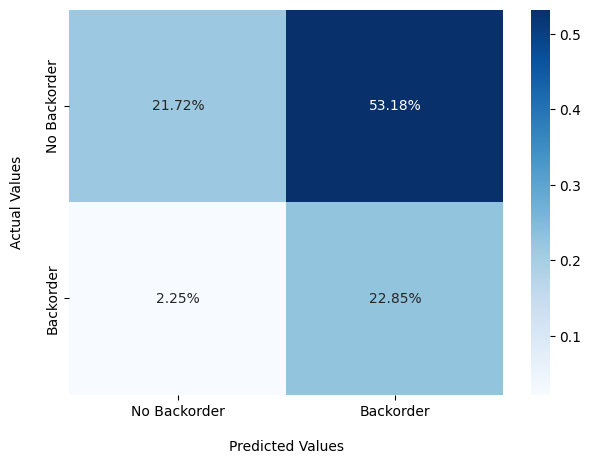

In [ ]:
cm = confusion_matrix(test_labels_svm,y_pred_1)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.savefig('cm2.png')
plt.show()

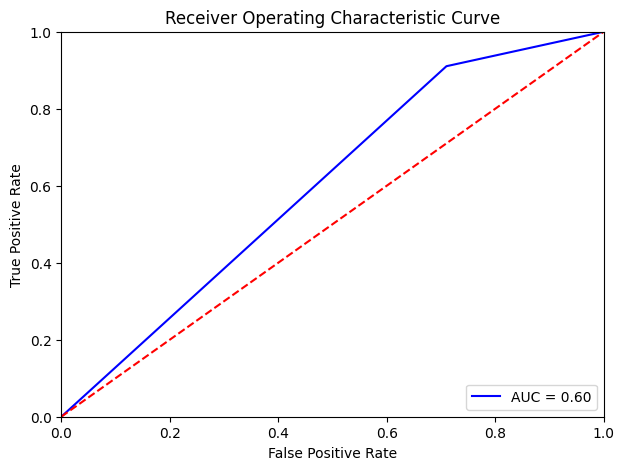

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test_labels_svm, y_pred_1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_curve2.png')
plt.show()

# vqc_base_qsvm_metaclassifier_stacking

In [ ]:
#converting two dimensional labels to 1D
train_labels_svm = train_labels[:,0]
test_labels_svm = test_labels[:,0]

seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map of VQC and QSVM
feature_map = ZZFeatureMap(feature_dim)

#ansatz we use in VQC
ansatz = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps = 2)

#initialize VQC
vqc = VQC(feature_map=feature_map,
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=100),
                 quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                 seed_simulator=seed,
                                                 seed_transpiler=seed)
                 )

#initialize kernel of QSVM
kernel = QuantumKernel(feature_map=feature_map,
                             quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                            shots=1,
                                            seed_simulator=seed,
                                                              seed_transpiler=seed))

#initialize QSVM
qsvc = QSVC(quantum_kernel=kernel)

In [ ]:
#train base classifiers and append features to data
#Use VQC and train data, append the predicted labels on train data to train data features 
from joblib import parallel_backend
with parallel_backend('multiprocessing'):  
    vqc.fit(train_data, train_labels)
    a = vqc.predict(train_data)
    label_1 = np.delete(a,1,1)
    train_added = np.append(train_data,label_1,1)
    print('done1')
    gc.collect()
    #append the predicted labels on test data to test data features
    d = vqc.predict(test_data)
    label_4 = np.delete(d,1,1)
    test_added = np.append(test_data,label_4,1)
    print('done2')
    gc.collect()

    qsvc.fit(train_added, train_labels_svm)
    y_pred_1 = qsvc.predict(test_added)
    gc.collect()
    print('done3')

done1
done2
done3


In [ ]:
classes = ['No Backorder','Backorder']
print(classification_report(test_labels_svm,y_pred_1,target_names=classes))
print(classification_report_imbalanced(test_labels_svm,y_pred_1,target_names=classes))
print(confusion_matrix(test_labels_svm,y_pred_1))

              precision    recall  f1-score   support

No Backorder       0.94      0.29      0.44       200
   Backorder       0.31      0.94      0.46        67

    accuracy                           0.45       267
   macro avg       0.62      0.62      0.45       267
weighted avg       0.78      0.45      0.45       267

                    pre       rec       spe        f1       geo       iba       sup

No Backorder       0.94      0.29      0.94      0.44      0.52      0.25       200
   Backorder       0.31      0.94      0.29      0.46      0.52      0.29        67

 avg / total       0.78      0.45      0.78      0.45      0.52      0.26       267

[[ 58 142]
 [  4  63]]


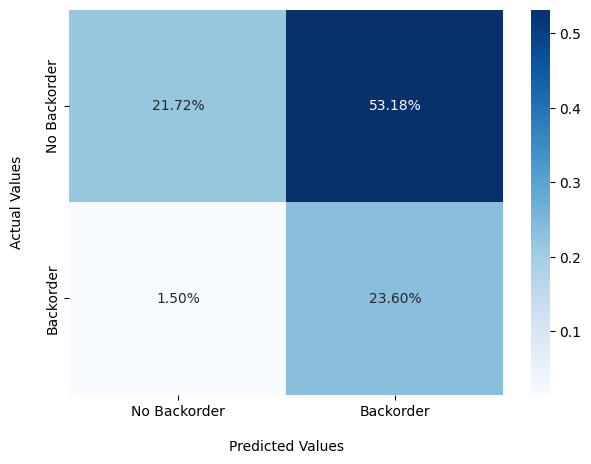

In [ ]:
cm = confusion_matrix(test_labels_svm,y_pred_1)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.savefig('cm3.png')
plt.show()

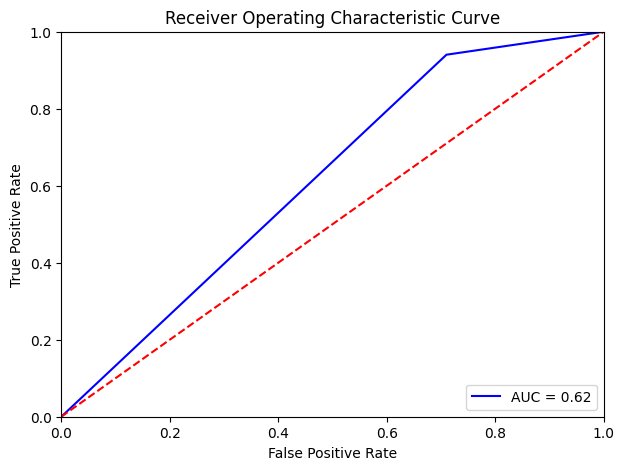

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test_labels_svm, y_pred_1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_curve3.png')
plt.show()